In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from textblob import TextBlob
import time
import requests


In [17]:
df = pd.read_csv("steam_games.csv")

df.head()

,AppID,Game Name,Game Tags,Release Date,Developer,Publisher,Price (in Rupees)
0,578080,PUBG: BATTLEGROUNDS,Survival Shooter Battle Royale Multiplayer FPS...,"21 Dec, 2017",PUBG Corporation,"KRAFTON, Inc.",Free To Play
1,1623730,Palworld,Open World Survival Creature Collector Multipl...,"18 Jan, 2024",Pocketpair,Pocketpair,"₹ 2,160"
2,1172470,Apex Legends™,Free to Play Battle Royale Multiplayer FPS Sho...,"4 Nov, 2020",Respawn,Electronic Arts,Free To Play
3,1063730,New World: Aeternum,Open World Massively Multiplayer MMORPG RPG Ad...,"28 Sep, 2021",Amazon Games,Amazon Games,"₹ 6,676"
4,550,Left 4 Dead 2,Zombies Co-op FPS Multiplayer Shooter Online C...,"16 Nov, 2009",Valve,Valve,₹ 720


In [14]:
def convert_price(price):
    # Extract digits from the price string
    match = re.findall(r'\d+', str(price).replace(',', ''))
    if match:
        return int(''.join(match))
    else:
        return 0

df['Price (in Rupees)'] = df['Price (in Rupees)'].apply(convert_price)

In [15]:
df.head()

,AppID,Game Name,Game Tags,Release Date,Developer,Publisher,Price (in Rupees)
0,578080,PUBG: BATTLEGROUNDS,Survival Shooter Battle Royale Multiplayer FPS...,"21 Dec, 2017",PUBG Corporation,"KRAFTON, Inc.",0
1,1623730,Palworld,Open World Survival Creature Collector Multipl...,"18 Jan, 2024",Pocketpair,Pocketpair,2160
2,1172470,Apex Legends™,Free to Play Battle Royale Multiplayer FPS Sho...,"4 Nov, 2020",Respawn,Electronic Arts,0
3,1063730,New World: Aeternum,Open World Massively Multiplayer MMORPG RPG Ad...,"28 Sep, 2021",Amazon Games,Amazon Games,6676
4,550,Left 4 Dead 2,Zombies Co-op FPS Multiplayer Shooter Online C...,"16 Nov, 2009",Valve,Valve,720


In [16]:
def fetch_steam_reviews(appid, num_reviews=100):
    url = f"https://store.steampowered.com/appreviews/{appid}?json=1&num_per_page={num_reviews}&language=english"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if 'reviews' in data:
                return [review['review'] for review in data['reviews']]
        return []
    except Exception as e:
        print(f"Error fetching for AppID {appid}: {e}")
        return []

# Store all reviews
all_reviews = []

for index, row in df.iterrows():
    appid = row['AppID']
    name = row['Game Name']

    reviews = fetch_steam_reviews(appid, num_reviews=100)
    
    if reviews:
        for r in reviews:
            all_reviews.append({'AppID': appid, 'Game Name': name, 'Review': r})

    print(f"[{index+1}/{len(df)}] {name} ({appid}) - {len(reviews)} reviews")
    time.sleep(1)  # sleep to avoid hammering Steam API

# Save to CSV
review_df = pd.DataFrame(all_reviews)
review_df.to_csv("steam_all_game_reviews.csv", index=False)
print("All reviews saved to 'steam_all_game_reviews.csv'")


[1/815] PUBG: BATTLEGROUNDS (578080) - 100 reviews
[2/815] Palworld (1623730) - 100 reviews
[3/815] Apex Legends™ (1172470) - 1 reviews
[4/815] New World: Aeternum (1063730) - 100 reviews
[5/815] Left 4 Dead 2 (550) - 99 reviews
[6/815] Unturned (304930) - 3 reviews
[7/815] Satisfactory (526870) - 100 reviews
[8/815] Battlefield™ V (1238810) - 98 reviews
[9/815] Ricochet (60) - 35 reviews
[10/815] NBA 2K20 (1089350) - 9 reviews
[11/815] Castle Crashers® (204360) - 100 reviews
[12/815] Risk of Rain 2 (632360) - 100 reviews
[13/815] The Tiny Bang Story (96000) - 4 reviews
[14/815] No Man's Sky (275850) - 99 reviews
[15/815] EA SPORTS™ FIFA 23 (1811260) - 33 reviews
[16/815] Geometry Dash (322170) - 100 reviews
[17/815] Dota Underlords (1046930) - 0 reviews
[18/815] No More Room in Hell (224260) - 100 reviews
[19/815] Minion Masters (489520) - 4 reviews
[20/815] Counter-Strike: Condition Zero (80) - 62 reviews
[21/815] Hearts of Iron IV (394360) - 100 reviews
[22/815] Deceit (466240) - 10

In [18]:
from nltk.corpus import stopwords

# Load your file
review_df = pd.read_csv("steam_all_game_reviews.csv")

# Preprocessing function
def preprocess_reviews(reviews):
    stop_words = set(stopwords.words('english'))
    clean_reviews = []

    for review in reviews:
        review = str(review).lower()
        review = re.sub(r"[^a-zA-Z\s]", "", review)
        tokens = re.findall(r'\b[a-zA-Z]{2,}\b', review)
        filtered_tokens = [word for word in tokens if word not in stop_words]
        clean_reviews.append(" ".join(filtered_tokens))

    return clean_reviews

# Apply it
review_df['Cleaned Review'] = preprocess_reviews(review_df['Review'])

# Save to new CSV
review_df.to_csv("steam_all_game_reviews_with_cleaned.csv", index=False)


In [19]:
import pandas as pd
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter

# Load your CSV
df = pd.read_csv("steam_all_game_reviews_with_cleaned.csv")

# Define bug/error-related keywords
error_keywords = [
    "bug", "bugs", "crash", "crashing", "crashed", "glitch", "glitches",
    "error", "issue", "lag", "lagging", "freezing", "freeze", "broken",
    "problem", "problems", "unplayable", "disconnect", "stuck", "slow"
]

# Filter bug-related reviews
df['is_bug_related'] = df['Cleaned Review'].apply(
    lambda x: any(keyword in str(x).lower() for keyword in error_keywords)
)

bug_df = df[df['is_bug_related']]

# Calculate bug percentage
bug_percentage = (len(bug_df) / len(df)) * 100 if len(df) > 0 else 0

# Sentiment analysis
bug_df['Sentiment Score'] = bug_df['Cleaned Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
bug_df['Sentiment'] = bug_df['Sentiment Score'].apply(
    lambda score: "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"
)

# Sentiment distribution
sentiment_distribution = Counter(bug_df['Sentiment'])

# Top keywords in bug reports
all_bug_words = " ".join(bug_df['Cleaned Review'].astype(str)).split()
word_freq = Counter(all_bug_words).most_common(15)

# Output
print(f"Bug/Error Mentions: {bug_percentage:.2f}% of total reviews.\n")
print("Sentiment Distribution on Bug-Related Reviews:")
for sentiment, count in sentiment_distribution.items():
    print(f"{sentiment}: {count} reviews")

print("\nTop 15 Frequent Words in Bug Reports:")
for word, freq in word_freq:
    print(f"{word}: {freq}")


Bug/Error Mentions: 14.75% of total reviews.

Sentiment Distribution on Bug-Related Reviews:
Negative: 3053 reviews
Positive: 3707 reviews
Neutral: 176 reviews

Top 15 Frequent Words in Bug Reports:
game: 20092
like: 4903
good: 4065
get: 3866
play: 3385
one: 3227
time: 3200
even: 2957
dont: 2768
games: 2690
really: 2553
fun: 2512
story: 2205
also: 2191
much: 2013


C:\Users\vinit\AppData\Local\Temp\ipykernel_18560\3870330897.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bug_df['Sentiment Score'] = bug_df['Cleaned Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
C:\Users\vinit\AppData\Local\Temp\ipykernel_18560\3870330897.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bug_df['Sentiment'] = bug_df['Sentiment Score'].apply(


In [20]:
# Step 0: Load Libraries
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Step 1: Load Data
df = pd.read_csv("steam_all_game_reviews_with_cleaned.csv")

# Step 2: Define Error Keywords
error_keywords = [
    "bug", "bugs", "crash", "crashing", "crashed", "glitch", "glitches",
    "error", "issue", "lag", "lagging", "freezing", "freeze", "broken",
    "problem", "problems", "unplayable", "disconnect", "stuck", "slow"
]
error_keywords_set = set(error_keywords)

# Step 3: Detect Reviews Containing Error Keywords
def contains_error_keywords(text):
    words = set(str(text).lower().split())
    return not error_keywords_set.isdisjoint(words)

df["Contains_Error_Keyword"] = df["Cleaned Review"].fillna("").apply(contains_error_keywords)

# Step 4: Bug/Error % per AppID
error_stats = df.groupby("AppID")["Contains_Error_Keyword"].agg(
    Total_Reviews="count",
    Error_Keyword_Reviews="sum"
)
error_stats["Error_Keyword_Percentage"] = (error_stats["Error_Keyword_Reviews"] / error_stats["Total_Reviews"]) * 100
error_stats = error_stats.reset_index()

# Step 5: Sentiment Analysis with VADER
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

df["Sentiment_Score"] = df["Cleaned Review"].fillna("").apply(lambda x: sia.polarity_scores(x)["compound"])

def categorize_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["Sentiment_Label"] = df["Sentiment_Score"].apply(categorize_sentiment)

# Optional: Save outputs
df.to_csv("reviews_with_error_sentiment.csv", index=False)
error_stats.to_csv("error_keyword_stats_per_appid.csv", index=False)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vinit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
sns.set(style="whitegrid")


C:\Users\vinit\AppData\Local\Temp\ipykernel_18560\51307864.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Sentiment_Label", order=["positive", "neutral", "negative"], palette="Set2")


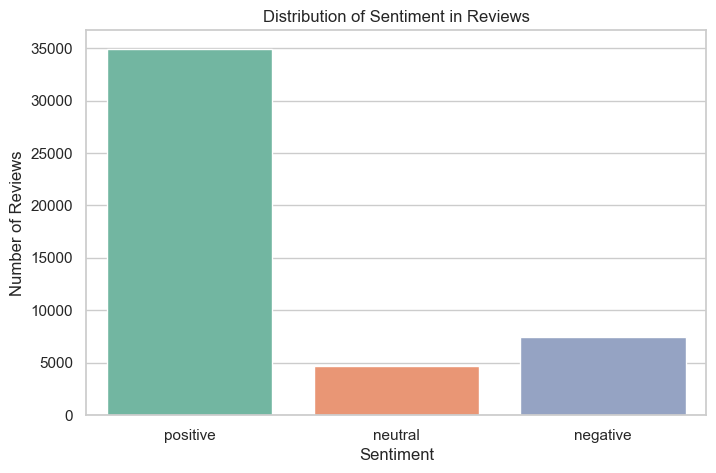

In [ ]:
# 1. Distribution of Sentiment Labels

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Sentiment_Label", order=["positive", "neutral", "negative"], palette="Set2")
plt.title("Distribution of Sentiment in Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

C:\Users\vinit\AppData\Local\Temp\ipykernel_18560\64764071.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Contains_Error_Keyword", palette="Set1")


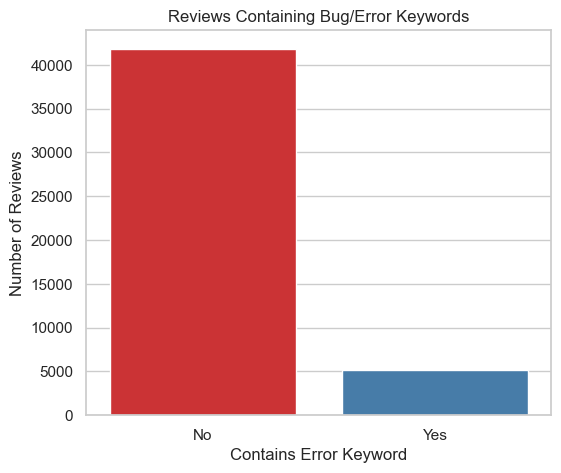

In [25]:
# Distribution of Reviews with Error Keywords
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x="Contains_Error_Keyword", palette="Set1")
plt.title("Reviews Containing Bug/Error Keywords")
plt.xlabel("Contains Error Keyword")
plt.ylabel("Number of Reviews")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

C:\Users\vinit\AppData\Local\Temp\ipykernel_18560\78362401.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_error_games.values, y=top_error_games.index, palette="Reds_r")


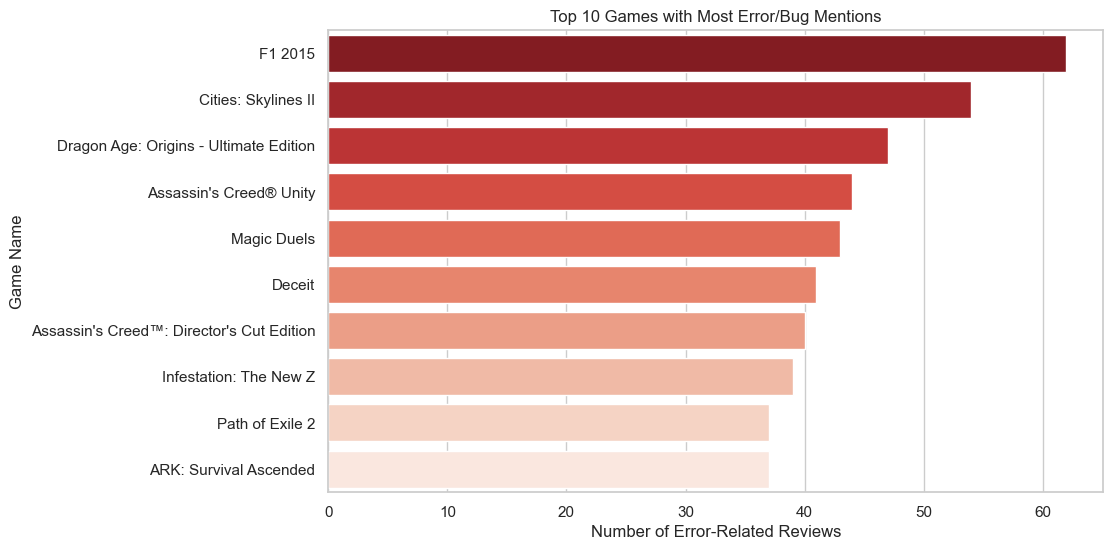

In [26]:
# 3. Top 10 Games with Most Error Mentions
# -------------------------------
top_error_games = df[df["Contains_Error_Keyword"]].groupby("Game Name").size().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_error_games.values, y=top_error_games.index, palette="Reds_r")
plt.title("Top 10 Games with Most Error/Bug Mentions")
plt.xlabel("Number of Error-Related Reviews")
plt.ylabel("Game Name")
plt.show()


In [27]:
# 4. Error Percentage by Game (Top 10 by Error %)
# -------------------------------
# Merge Game Name into error_stats
app_names = df[["AppID", "Game Name"]].drop_duplicates()
error_stats_named = error_stats.merge(app_names, on="AppID", how="left")

In [28]:
# Get Top 10 by error % (with at least 30 reviews to filter noise)
filtered = error_stats_named[error_stats_named["Total_Reviews"] >= 30]
top_error_pct = filtered.sort_values("Error_Keyword_Percentage", ascending=False).head(10)

C:\Users\vinit\AppData\Local\Temp\ipykernel_18560\3596911293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Error_Keyword_Percentage", y="Game Name", data=top_error_pct, palette="coolwarm")


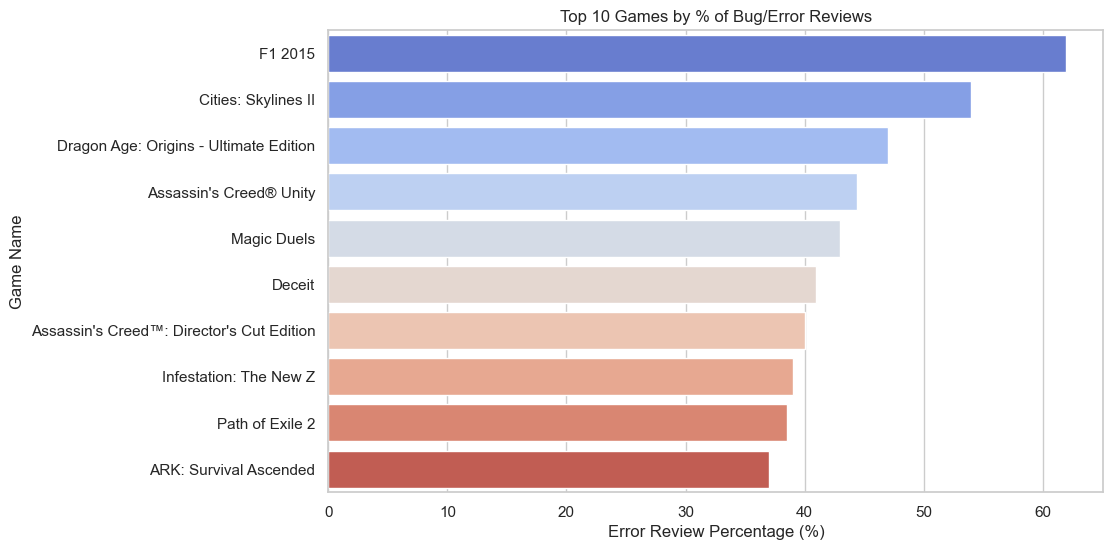

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Error_Keyword_Percentage", y="Game Name", data=top_error_pct, palette="coolwarm")
plt.title("Top 10 Games by % of Bug/Error Reviews")
plt.xlabel("Error Review Percentage (%)")
plt.ylabel("Game Name")
plt.show()

C:\Users\vinit\AppData\Local\Temp\ipykernel_18560\596344034.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df["Contains_Error_Keyword"]], x="Sentiment_Label", order=["positive", "neutral", "negative"], palette="muted")


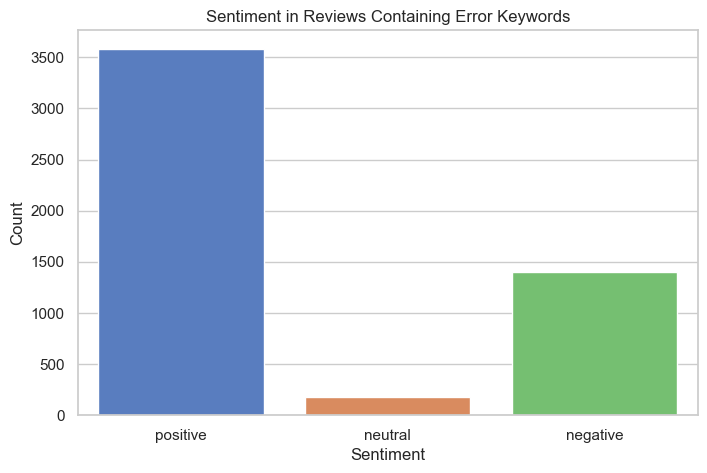

In [30]:
# 5. Sentiment Distribution in Error Reviews
# -------------------------------
plt.figure(figsize=(8, 5))
sns.countplot(data=df[df["Contains_Error_Keyword"]], x="Sentiment_Label", order=["positive", "neutral", "negative"], palette="muted")
plt.title("Sentiment in Reviews Containing Error Keywords")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
"""np.random.seed(42)
def mock_reviews():
    samples = [
        "Game crashes often.",
        "Loved the graphics, but buggy AI.",
        "Smooth experience, no issues.",
        "Encountered major bugs during missions.",
        "Great multiplayer mode."
    ]
    return np.random.choice(samples, size=20, replace=True).tolist()"""

In [ ]:
"""df["Reviews"] = df["AppID"].apply(lambda x: mock_reviews())
"""

In [ ]:
"""stop_words = set(stopwords.words("english"))

def preprocess_reviews(reviews):
    clean_reviews = []
    for review in reviews:
        review = review.lower()
        review = re.sub(r"[^a-zA-Z\s]", "", review)
        words = review.split()
        filtered = [word for word in words if word not in stop_words]
        clean_reviews.append(" ".join(filtered))
    return clean_reviews

df["Cleaned Reviews"] = df["Reviews"].apply(preprocess_reviews)"""

In [ ]:
"""def is_bug_related(review_list):
    bug_keywords = ["bug", "error", "crash", "glitch", "issue", "problem"]
    bug_reviews = [r for r in review_list if any(kw in r for kw in bug_keywords)]
    return bug_reviews

df["Bug Reviews"] = df["Cleaned Reviews"].apply(is_bug_related)"""

In [ ]:
"""def sentiment_score(reviews):
    if not reviews:
        return 0
    return np.mean([TextBlob(r).sentiment.polarity for r in reviews])

df["Bug Sentiment"] = df["Bug Reviews"].apply(sentiment_score)

# Flag negative bug reviews
df["Negative Bug"] = df["Bug Sentiment"] < 0"""

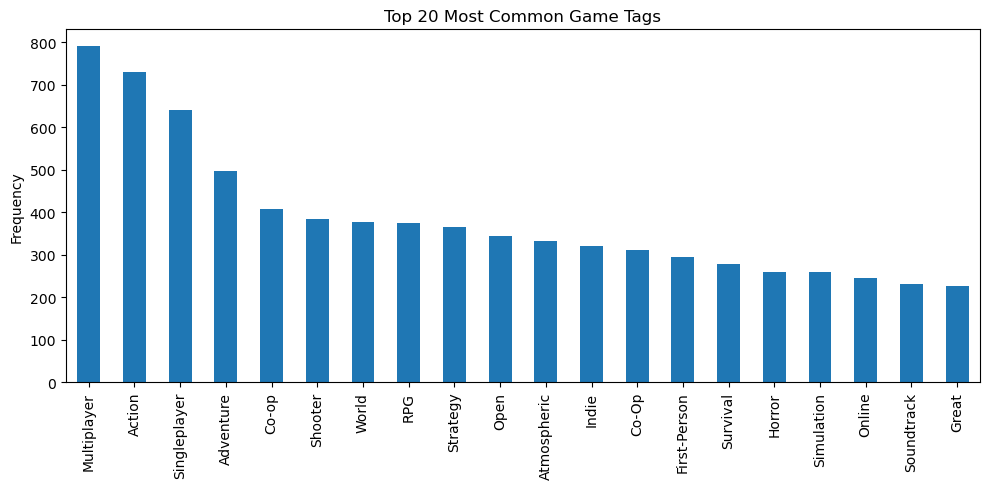

In [ ]:
"""
plt.figure(figsize=(10,5))
df['Game Tags'].str.split().explode().value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Most Common Game Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()"""

In [ ]:
"""df_price = df.dropna(subset=["Price (in Rupees)"])
kmeans = KMeans(n_clusters=4, random_state=42)
df_price["Price Cluster"] = kmeans.fit_predict(df_price[["Price (in Rupees)"]])


#############


plt.figure(figsize=(8,5))
sns.boxplot(data=df_price, x="Price Cluster", y="Price (in Rupees)")
plt.title("Price Clusters")
plt.tight_layout()
plt.show()"""

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
"""cluster_bug = df_price.groupby("Price Cluster")["Negative Bug"].mean()
cluster_bug.plot(kind='bar', title="Avg % of Games with Negative Bug Reviews per Price Cluster")
plt.ylabel("Proportion of Negative Bugs")
plt.xlabel("Price Cluster")
plt.show()

# Publisher vs. negative bugs
pub_bug = df.groupby("Publisher")["Negative Bug"].mean().sort_values(ascending=False).head(10)
pub_bug.plot(kind="barh", title="Top 10 Publishers with Most Negative Bug Reviews")
plt.xlabel("Avg Negative Bug Rate")
plt.show()

# Timeline of release vs bugs
df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
df_time = df.dropna(subset=["Release Date"])
df_time.set_index("Release Date")["Negative Bug"].resample("M").mean().plot(title="Negative Bug Trends Over Time")
plt.ylabel("Proportion Negative Bugs")
plt.show()

# Most buggy game tags
tag_bug = df.explode("Game Tags".split()).copy()
tag_bug['Each Tag'] = tag_bug['Game Tags'].str.split()
tag_bug = tag_bug.explode("Each Tag")
tag_bug = tag_bug.groupby("Each Tag")["Negative Bug"].mean().sort_values(ascending=False).head(15)
tag_bug.plot(kind="bar", title="Most Buggy Tags")
plt.ylabel("Avg Negative Bug Rate")
plt.xticks(rotation=45)
plt.show()

# Average price by year
if df["Release Date"].dtype == 'datetime64[ns]':
    df["Year"] = df["Release Date"].dt.year
    df.groupby("Year")["Price (in Rupees)"].mean().plot(title="Avg Price of Games per Year")
    plt.ylabel("Average Price (INR)")
    plt.show()

# Publisher count
pub_count = df["Publisher"].value_counts().head(10)
pub_count.plot(kind='bar', title="Top 10 Publishers by Number of Games")
plt.ylabel("Game Count")
plt.xticks(rotation=45)
plt.show()
"""

KeyError: 'Price Cluster'